In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras 
import tensorflow as tf
import os
import time
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
class ReboilerBinaryClassifier:
    FEATURES_NUM = 8
    OUTPUT_NUM = 2

    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self):
        return pd.read_csv(self.filepath)
        
    def generate_full_pipeline(self, X):
        num_attribs = X.select_dtypes(exclude=['object']).columns.tolist() # numerical attributes
        cat_attribs = X.select_dtypes(include=['object']).columns.tolist() # categorical attributes. In this case, it is only the 'Fecha' column.       
        
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), # fill missing values with column mean
            ('min_max_scaler', MinMaxScaler()) # scale the data between 0 and 1
        ])
        
        full_pipeline = ColumnTransformer([
            ('num', num_pipeline, num_attribs), # apply the numerical pipeline to the numerical attributes
            ('cat', CustomDataFormatter(cat_attribs), cat_attribs) # apply the custom class to convert text to datetime
        ])
        
        return full_pipeline


    # def process(self, pandas_df):
    #     #TODO: Replace this method by Pipeline (from Tensorflow)
    #     # fill missing values
    #     for col in pandas_df:
    #         if pandas_df[col].isnull().any(): # if column has at least one NaN value
    #             pandas_df[col].fillna(value=pandas_df[col].mean(), inplace=True) # replace NaN with average
            
    #         # min-max scaling (normalization)
    #         if pd.to_numeric(pandas_df[col], errors='coerce').notnull().all(): # if columns is composed only by numeric values        
    #             pandas_df[col] = (pandas_df[col]-pandas_df[col].min())/(pandas_df[col].max()-pandas_df[col].min())

    #     # hard code to convert 'Fecha' column to datetime ex: 2006-10-24 23:38:00
    #     pandas_df['Fecha'] =  pd.to_datetime(pandas_df['Fecha'], format='%Y-%m-%d %H:%M:%S')

    #     return pandas_df         
                
    def split_data(self, data, val_size=0.2, test_size=0.2):
        X = data.iloc[:, 1:-1] # all rows, all columns except first (datetime) and last (label)
        y = data.iloc[:, -1] # all rows, last column (label)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size, random_state=42)        
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=42)

        pipeline = self.generate_full_pipeline(X_train)
        X_train = pipeline.fit_transform(X_train)
        X_val = pipeline.transform(X_val)
        X_test = pipeline.transform(X_test)

        return X_train, y_train, X_val, y_val, X_test, y_test

    ########################## NEURAL NETWORK MODEL ##########################
    
    def create_model(self, print_summary=True):    

        model = keras.models.Sequential([
            keras.layers.Dense(32, input_shape=(ReboilerBinaryClassifier.FEATURES_NUM,), activation='sigmoid'),
            # keras.layers.Dense(ReboilerBinaryClassifier.OUTPUT_NUM-1, activation="sigmoid")
            keras.layers.Dense(ReboilerBinaryClassifier.OUTPUT_NUM, activation="softmax")
        ])

        model.compile(
            loss='sparse_categorical_crossentropy', # with softmax (e.g. 0, 1, 2, 3, 4...)
            # loss="binary_crossentropy", # with sigmoid (e.g. 0 or 1)
            optimizer="adam",
            metrics=["accuracy"]
        )
        if print_summary:
            model.summary()

        return model
    
    def train_model(self, model, X_train, y_train, X_val, y_val, epochs, *, name=None):
        run_logdir = self.get_run_logdir(name)
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir) # create event files within run_logdir
        history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[tensorboard_cb])


    def evaluate_model(self, model, X_test, y_test, save_confusion_matrix=True):
        y_prob = model.predict(X_test) # probabilities
        y_pred = y_prob.argmax(axis=-1) # predictions
        # accuracy = model.evaluate(X_test, y_test)[1] # [loss, accuracy]
        accuracy = accuracy_score(y_test, y_pred)
        print('Accuracy on test set: {}'.format(accuracy))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical', cmap='Blues', colorbar=False)
        plt.suptitle('Confusion Matrix - {}'.format(model))
        plt.grid(False)   
        if save_confusion_matrix:
            plt.savefig("confusion-matrix.png", dpi=300)
        plt.show()

    def plot_roc_curve(self, model, X_test, y_test, save_roc_curve=True, label='Neural Network'):
        y_scores = model.predict(X_test)[:, -1] # probabilities of positive cases "1"
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        print('AUC =', roc_auc_score(y_test, y_scores))
        plt.plot(fpr, tpr, label=label)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate (Recall)')
        plt.title('ROC Curve')
        plt.legend()
        if save_roc_curve:
            plt.savefig("roc_curve.png", dpi=300)
        plt.show()

    def save_model(self, model, name='model'):
        name += '.h5'
        model.save(name)

    def load_model(self, model):
        return keras.models.load_model(model)

    ########################## AUXILIARY METHODS ##########################

    @staticmethod
    def get_run_logdir(name=None):    
        root_logdir = os.path.join(os.curdir, "logs")
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S") if name is None else name
        return os.path.join(root_logdir, run_id)
    
class CustomDataFormatter(BaseEstimator, TransformerMixin):
    '''code to convert 'Fecha' column to datetime ex: 2006-10-24 23:38:00 '''
    def __init__(self, data_column):
        self.data_column = data_column
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.data_column] = pd.to_datetime(X[self.data_column], format='%Y-%m-%d %H:%M:%S')



In [3]:
r = ReboilerBinaryClassifier('Reboiler_Raw Data_With Timestamps.csv')

In [4]:
r_pandas = r.load_data()

In [5]:
r_pandas.head()

,Fecha,VAL356CI8017-Conductividad,VAL356M003-Carga Motor,VAL356M014-Carga Motor,VAL356M015-Carga Motor,VAL356PI8026-Ind.Presión,VAL356PIC8025-Ind.Presión,VAL356TI8015-Ind.Temperatura,VAL356TIC8014-Ind.Temperatura,Estado
0,2006-10-24 23:38:00,12.3,68.026459,45.670056,30.343173,21.492553,20.9,71.883617,103.414846,0
1,2006-10-25 01:38:00,18.9,68.827098,45.924569,30.126654,20.954956,20.6,72.301453,103.487449,0
2,2006-10-25 03:38:00,25.9,68.871664,49.477196,29.701442,21.193045,20.3,71.775536,103.582936,0
3,2006-10-25 05:38:00,27.2,65.658285,51.649763,28.820497,21.021897,20.6,70.589861,103.697800,0
4,2006-10-25 07:38:00,22.0,64.166553,46.851182,27.760388,20.975880,20.4,71.762377,103.680362,0


In [6]:
r_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42206 entries, 0 to 42205
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Fecha                          42206 non-null  object 
 1   VAL356CI8017-Conductividad     42206 non-null  float64
 2   VAL356M003-Carga Motor         28157 non-null  float64
 3   VAL356M014-Carga Motor         42165 non-null  float64
 4   VAL356M015-Carga Motor         42184 non-null  float64
 5   VAL356PI8026-Ind.Presión       42159 non-null  float64
 6   VAL356PIC8025-Ind.Presión      42161 non-null  float64
 7   VAL356TI8015-Ind.Temperatura   41711 non-null  float64
 8   VAL356TIC8014-Ind.Temperatura  42129 non-null  float64
 9   Estado                         42206 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 3.2+ MB


In [7]:
r_pandas.describe()

,VAL356CI8017-Conductividad,VAL356M003-Carga Motor,VAL356M014-Carga Motor,VAL356M015-Carga Motor,VAL356PI8026-Ind.Presión,VAL356PIC8025-Ind.Presión,VAL356TI8015-Ind.Temperatura,VAL356TIC8014-Ind.Temperatura,Estado
count,4.220600e+04,28157.000000,42165.000000,42184.000000,42159.000000,42161.000000,41711.000000,42129.000000,42206.000000
mean,4.356374e+29,68.956796,56.445749,40.740753,22.476892,22.181314,78.795998,100.915903,0.063119
std,3.680794e+31,13.890744,21.842974,9.853423,15.581274,14.913822,13.062851,16.227754,0.243180
min,0.000000e+00,0.000000,0.000000,0.000000,6.750819,6.300000,2.420921,4.211509,0.000000
25%,2.700000e+00,69.067003,40.115919,38.059504,18.066066,18.000000,78.010475,100.249657,0.000000
50%,3.600000e+00,71.690179,67.605180,42.458699,19.742613,19.600000,79.425542,101.056192,0.000000
75%,4.700000e+00,74.073147,73.160478,45.564994,20.578718,20.500000,81.520222,105.428089,0.000000
max,4.000000e+33,105.568840,86.441951,65.909472,123.519166,108.400000,137.730075,160.440382,1.000000


array([[<AxesSubplot: title={'center': 'VAL356CI8017-Conductividad'}>,
        <AxesSubplot: title={'center': 'VAL356M003-Carga Motor'}>,
        <AxesSubplot: title={'center': 'VAL356M014-Carga Motor'}>],
       [<AxesSubplot: title={'center': 'VAL356M015-Carga Motor'}>,
        <AxesSubplot: title={'center': 'VAL356PI8026-Ind.Presión'}>,
        <AxesSubplot: title={'center': 'VAL356PIC8025-Ind.Presión'}>],
       [<AxesSubplot: title={'center': 'VAL356TI8015-Ind.Temperatura'}>,
        <AxesSubplot: title={'center': 'VAL356TIC8014-Ind.Temperatura'}>,
        <AxesSubplot: title={'center': 'Estado'}>]], dtype=object)

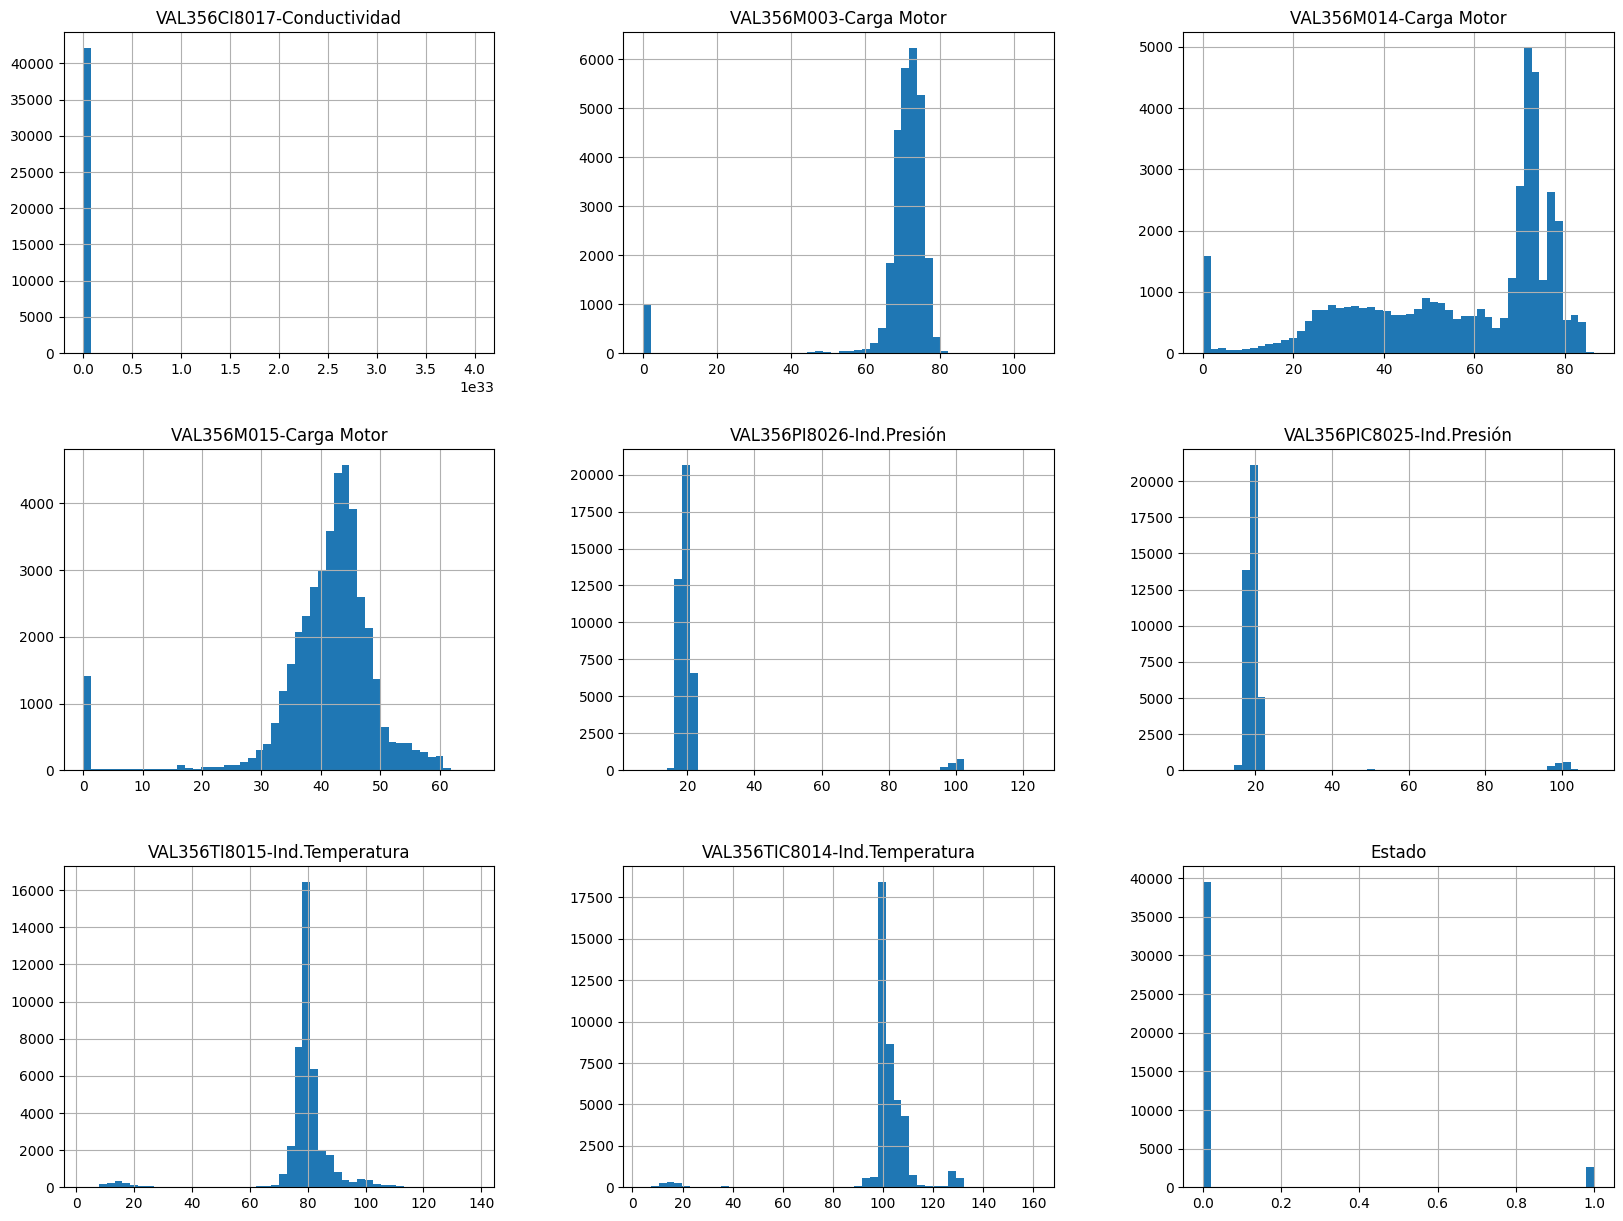

In [8]:
%matplotlib inline
r_pandas.hist(bins=50, figsize=(20,15))

In [9]:
r_pandas.shape

(42206, 10)

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = r.split_data(r_pandas)

In [11]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (27011, 8)
y_train (27011,)
X_val (6753, 8)
y_val (6753,)
X_test (8442, 8)
y_test (8442,)


In [12]:
X_train

array([[1.17500000e-33, 6.52868287e-01, 8.28020248e-01, ...,
        8.48484848e-02, 5.83564494e-01, 6.23090947e-01],
       [7.50000000e-34, 6.50810469e-01, 4.94704267e-01, ...,
        1.14141414e-01, 5.66884717e-01, 6.54514680e-01],
       [7.25000000e-34, 6.67133681e-01, 3.88772460e-01, ...,
        1.15151515e-01, 5.77827068e-01, 7.94639492e-01],
       ...,
       [1.12500000e-33, 6.52868287e-01, 8.26946432e-01, ...,
        8.98989899e-02, 7.59384937e-01, 6.63106862e-01],
       [9.25000000e-34, 6.79740152e-01, 2.65105262e-01, ...,
        1.00000000e-01, 5.57027314e-01, 6.22760112e-01],
       [1.15000000e-33, 6.52868287e-01, 8.36715007e-01, ...,
        8.98989899e-02, 5.87619896e-01, 6.15525669e-01]])

In [13]:
model = r.create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________


In [14]:
r.train_model(model, X_train, y_train, X_val, y_val, epochs=10, name=None)

Epoch 1/10
845/845 [==============================] - 4s 3ms/step - loss: 0.2335 - accuracy: 0.9357 - val_loss: 0.2246 - val_accuracy: 0.9365
Epoch 2/10
845/845 [==============================] - 2s 2ms/step - loss: 0.2205 - accuracy: 0.9357 - val_loss: 0.2127 - val_accuracy: 0.9365
Epoch 3/10
845/845 [==============================] - 2s 2ms/step - loss: 0.2065 - accuracy: 0.9357 - val_loss: 0.1973 - val_accuracy: 0.9365
Epoch 4/10
845/845 [==============================] - 2s 2ms/step - loss: 0.1898 - accuracy: 0.9357 - val_loss: 0.1801 - val_accuracy: 0.9365
Epoch 5/10
845/845 [==============================] - 2s 2ms/step - loss: 0.1708 - accuracy: 0.9357 - val_loss: 0.1610 - val_accuracy: 0.9365
Epoch 6/10
845/845 [==============================] - 2s 2ms/step - loss: 0.1504 - accuracy: 0.9365 - val_loss: 0.1404 - val_accuracy: 0.9381
Epoch 7/10
845/845 [==============================] - 2s 2ms/step - loss: 0.1296 - accuracy: 0.9405 - val_loss: 0.1220 - val_accuracy: 0.9491
Epoch 

In [20]:
%reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

Reusing TensorBoard on port 6006 (pid 295), started 0:00:12 ago. (Use '!kill 295' to kill it.)

In [16]:
r.save_model(model)

In [17]:
loaded_model = r.load_model('model.h5')

264/264 [==============================] - 0s 1ms/step
Accuracy on test set: 0.9772565742714996


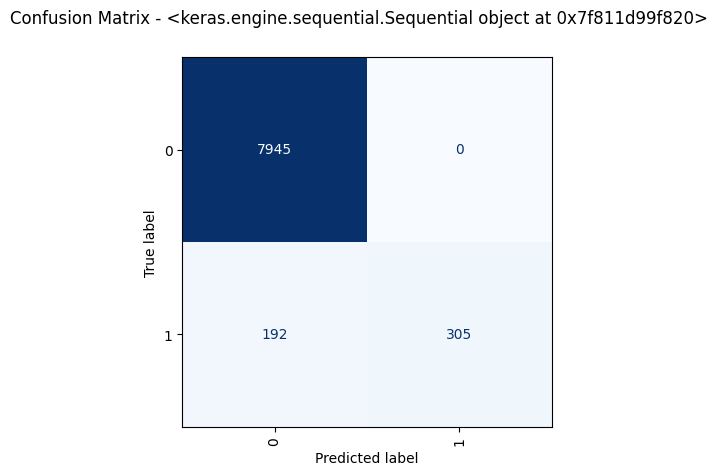

In [18]:
r.evaluate_model(loaded_model, X_test, y_test)

264/264 [==============================] - 0s 1ms/step
AUC = 0.9955547001328298


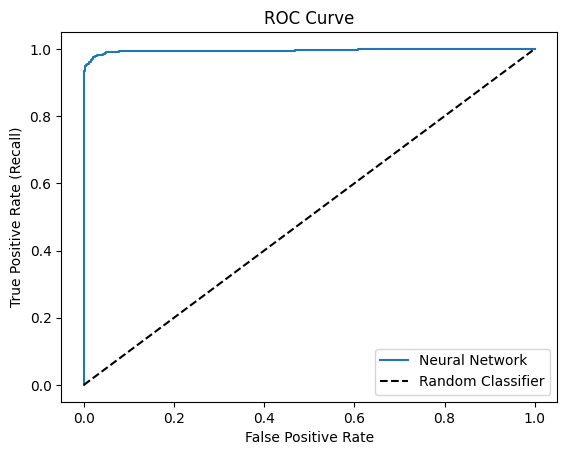

In [19]:
r.plot_roc_curve(loaded_model, X_test, y_test)